<a href="https://colab.research.google.com/github/fishpersonn/20220503/blob/main/LDA%E4%BB%A5500%E6%A2%9D%E8%A8%8A%E6%81%AF%E8%A9%A6%E8%B7%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib as plt

import warnings
warnings.filterwarnings("ignore")
!pip install ckip-transformers==0.3.1

In [2]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
# Initialize drivers
print("Initializing drivers ... WS")
ws_driver = CkipWordSegmenter(model="bert-base", device=0)
print("Initializing drivers ... POS")
pos_driver = CkipPosTagger(model="bert-base", device=0)
print("Initializing drivers ... NER")
ner_driver = CkipNerChunker(model="bert-base", device=0)
print("Initializing drivers ... all done")
print()

Initializing drivers ... WS


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Initializing drivers ... POS


config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Initializing drivers ... NER


config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Initializing drivers ... all done



In [7]:
ORIGINAL_DATA = pd.read_csv("/content/Cleaned_metoodata_1105goodUTF8.csv")

ORIGINAL_DATA.head()


,text,date,author
0,即時中心／綜合報導根據法庭檔案，曾任美國選秀節目《美國偶像》與《舞林爭霸》評審的寶拉阿巴杜（...,2023/12/31,中天新聞
1,投稿網址： too，但同科專師卻說因為人力不夠要相挺？性騷擾零容忍！為何護理師要容忍？換單位...,2023/12/31,靠北護理師
2,2023年最後一揭發，2024年下架民進黨！#揭發民進黨 EP.10 #護航性騷今年上半年，...,2023/12/31,侯漢廷
3,笑話！,2023/12/31,青青
4,加油！我一定投你一票💪,2023/12/31,孫凱莉


In [8]:
# 讀取數據
ORIGINAL_DATA = pd.read_csv("/content/Cleaned_metoodata_1105goodUTF8.csv")

# 從原始數據中隨機抽樣 500 條
TEST_DATA = ORIGINAL_DATA.sample(n=500, random_state=42)

# 獲取 `text` 欄位內容
content = TEST_DATA["text"]

# 查看前 10 條內容
print(content.head(10))


297024          Hsin Cheng 反正你承認自己舔就好，舔到你舌頭怎樣也不關我的事！你繼續慢慢舔！
368789                                     這時候...3+11雲 又啞巴了
325546    我想到了1個辦法，凡自發性支持郭董的民眾，有沒有人可以統一做個旗子，寫唯一支持郭台銘，中華民...
374282          那麼恩恩呢？？？恩恩呢？？？恩恩事件您追根究底了嗎？？？一個孩子的命那麼不重要嗎？？？
157518                               Rambo Chung 笑死 你留的言真保守
130901                                              這個是彩繪火車
205245                                               這種人別交往
271373                                             當場沒給巴掌？？
79088     鄭賈裕 #Viral=1 facebook.com/l.php?u=fde08e6dcd.b...
12634                                                恭喜法院認證
Name: text, dtype: object


In [9]:
# 匯入停用詞
def read_stopword():
    with open("/content/cn_stopwords.csv", "r", encoding="utf-8") as f:
        stopword = [word.strip("\n") for word in f.readlines()]
    return stopword
stopwords = read_stopword()

# 對文章進行斷詞
def do_CKIP_WS(article):
    ws_results = ws_driver([str(article)])
    return ws_results

# 對詞組進行詞性標示
def do_CKIP_POS(ws_result):
    pos = pos_driver(ws_result[0])
    all_list = []
    for sent in pos:

        all_list.append(sent)
    return all_list

# 保留名詞與動詞
def pos_filter(pos):
    for i in list(set(pos)):
        if i.startswith("N") or i.startswith("V"):
            return "Yes"
        else:
            continue

# 去除數字與網址詞組
def remove_number_url(ws):
    number_pattern = "^\d+\.?\d*"
    url_pattern = "^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
    space_pattern = "^ .*"
    num_regex = re.match(number_pattern, ws)
    url_regex = re.match(url_pattern, ws)
    space_regex = re.match(space_pattern, ws)
    if num_regex ==  None and url_regex == None and space_regex == None:
        return True
    else:
        return False

# 執行資料清洗
def cleaner(ws_results, pos_results, stopwords):
    word_lst = []
    for ws, pos in zip(ws_results[0], pos_results):
        in_stopwords_or_not = ws not in stopwords  #詞組是否存為停用詞
        if_len_greater_than_1 = len(ws) > 1        #詞組長度必須大於1
        is_V_or_N = pos_filter(pos)                #詞組是否為名詞、動詞
        is_num_or_url = remove_number_url(ws)      #詞組是否為數字、網址、空白開頭
        if in_stopwords_or_not and if_len_greater_than_1 and is_V_or_N == "Yes" and is_num_or_url:
            word_lst.append(str(ws))
        else:
            pass
    return word_lst

In [10]:
seg_lst = []
for i in range(len(TEST_DATA)):
    ws_results = do_CKIP_WS(content.iloc[i])
    pos_results = do_CKIP_POS(ws_results)
    word_lst = cleaner(ws_results, pos_results, stopwords)
    seg_lst.append(word_lst)

Inference: 100%|██████████| 1/1 [00:00<00:00, 95.91it/s]


In [11]:
!pip install wordcloud matplotlib

In [12]:
# 將 seg_lst 中的詞語展平成一個列表
all_words = [word for sublist in seg_lst for word in sublist]

# 合併為一個字符串
text_for_wordcloud = " ".join(all_words)

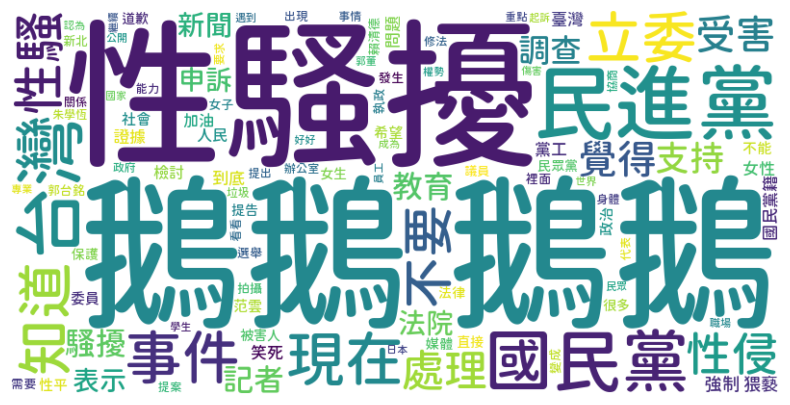

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 設定文字雲參數
wordcloud = WordCloud(
    font_path='/content/GenSenRounded2-M.ttc',  # 字型檔案路徑（適合中文）
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(text_for_wordcloud)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


#使用gensim函式庫來進行LDA模型的實作

In [16]:
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint

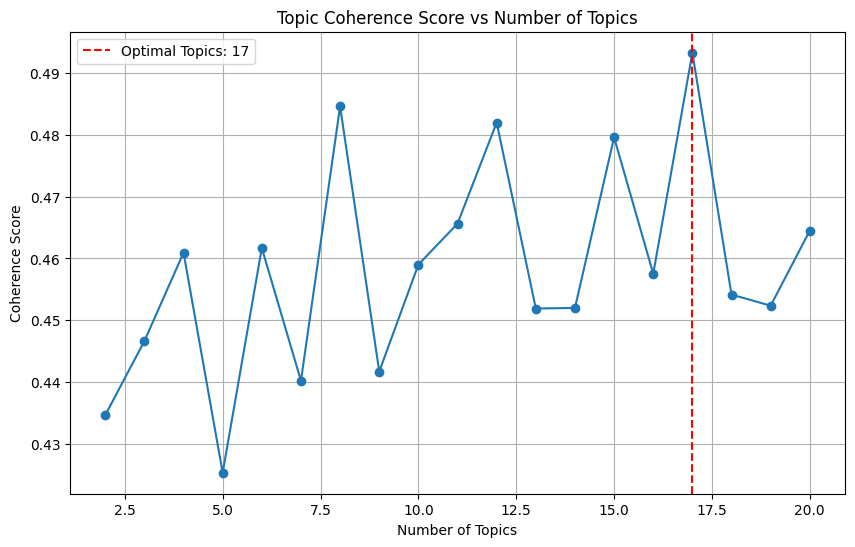


Top keywords for each topic:
Topic 0: 0.011*"老公" + 0.009*"恩恩" + 0.009*"老闆" + 0.006*"詐騙" + 0.006*"認識" + 0.006*"覺得" + 0.006*"擁護" + 0.006*"保護" + 0.006*"正牌" + 0.006*"女友"
Topic 1: 0.020*"調查" + 0.017*"性騷擾" + 0.016*"申訴" + 0.015*"被害人" + 0.011*"提出" + 0.010*"民進黨" + 0.008*"要求" + 0.008*"性騷" + 0.008*"專業" + 0.008*"人員"
Topic 2: 0.014*"性騷擾" + 0.014*"拍攝" + 0.009*"女優" + 0.009*"笑死" + 0.007*"表示" + 0.007*"媒體" + 0.007*"民眾" + 0.007*"民進黨" + 0.007*"發生" + 0.007*"爆料"
Topic 3: 0.016*"國民黨" + 0.013*"國民黨籍" + 0.011*"性侵" + 0.010*"立委" + 0.010*"性騷擾" + 0.007*"女子" + 0.006*"辦公室" + 0.006*"記者" + 0.006*"騷擾" + 0.005*"副主任"
Topic 4: 0.009*"加油" + 0.008*"色情" + 0.008*"日本" + 0.008*"師父" + 0.008*"性騷" + 0.008*"教育" + 0.008*"人生" + 0.008*"弱點" + 0.005*"性騷擾" + 0.005*"性平"
Topic 5: 0.021*"支持" + 0.012*"郭董" + 0.009*"旗子" + 0.006*"民進黨" + 0.006*"逮捕" + 0.006*"低能" + 0.006*"同志" + 0.006*"不要" + 0.006*"郭台銘" + 0.006*"發起"
Topic 6: 0.013*"處理" + 0.008*"很多" + 0.008*"性騷擾" + 0.008*"主席" + 0.005*"確實" + 0.005*"受害" + 0.005*"團結" + 0.005*"添加" + 0.005*"笑話" + 0.005*"

In [17]:
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import numpy as np

# Create dictionary and corpus
dictionary = corpora.Dictionary(seg_lst)
corpus = [dictionary.doc2bow(i) for i in seg_lst]

def calculate_coherence(start_topics=2, end_topics=20, step=1):
    """
    Calculate coherence scores for different numbers of topics
    """
    coherence_scores = []
    topic_numbers = range(start_topics, end_topics+1, step)

    for num_topics in topic_numbers:
        # Train LDA model
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=30
        )

        # Calculate coherence score
        coherence_model = CoherenceModel(
            model=lda,
            texts=seg_lst,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_scores.append(coherence_model.get_coherence())

    return topic_numbers, coherence_scores

def plot_coherence(topic_numbers, coherence_scores):
    """
    Plot coherence scores against number of topics
    """
    plt.figure(figsize=(10, 6))
    plt.plot(list(topic_numbers), coherence_scores, marker='o')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Topic Coherence Score vs Number of Topics')
    plt.grid(True)

    # Find optimal number of topics
    optimal_topics = list(topic_numbers)[np.argmax(coherence_scores)]
    plt.axvline(x=optimal_topics, color='r', linestyle='--',
                label=f'Optimal Topics: {optimal_topics}')
    plt.legend()
    plt.show()

    return optimal_topics

# Calculate and plot coherence scores
topic_numbers, coherence_scores = calculate_coherence()
optimal_topics = plot_coherence(topic_numbers, coherence_scores)

# Train final model with optimal number of topics
final_lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_topics,
    random_state=42,
    passes=30
)

print(f"\nTop keywords for each topic:")
for idx, topic in final_lda.print_topics(num_words=10):
    print(f'Topic {idx}: {topic}')

In [18]:
num_topics = 17
lda = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 30, random_state = 42)
topics_lst = lda.print_topics()
print(topics_lst)

[(0, '0.011*"老公" + 0.009*"恩恩" + 0.009*"老闆" + 0.006*"詐騙" + 0.006*"認識" + 0.006*"覺得" + 0.006*"擁護" + 0.006*"保護" + 0.006*"正牌" + 0.006*"女友"'), (1, '0.020*"調查" + 0.017*"性騷擾" + 0.016*"申訴" + 0.015*"被害人" + 0.011*"提出" + 0.010*"民進黨" + 0.008*"要求" + 0.008*"性騷" + 0.008*"專業" + 0.008*"人員"'), (2, '0.014*"性騷擾" + 0.014*"拍攝" + 0.009*"女優" + 0.009*"笑死" + 0.007*"表示" + 0.007*"媒體" + 0.007*"民眾" + 0.007*"民進黨" + 0.007*"發生" + 0.007*"爆料"'), (3, '0.016*"國民黨" + 0.013*"國民黨籍" + 0.011*"性侵" + 0.010*"立委" + 0.010*"性騷擾" + 0.007*"女子" + 0.006*"辦公室" + 0.006*"記者" + 0.006*"騷擾" + 0.005*"副主任"'), (4, '0.009*"加油" + 0.008*"色情" + 0.008*"日本" + 0.008*"師父" + 0.008*"性騷" + 0.008*"教育" + 0.008*"人生" + 0.008*"弱點" + 0.005*"性騷擾" + 0.005*"性平"'), (5, '0.021*"支持" + 0.012*"郭董" + 0.009*"旗子" + 0.006*"民進黨" + 0.006*"逮捕" + 0.006*"低能" + 0.006*"同志" + 0.006*"不要" + 0.006*"郭台銘" + 0.006*"發起"'), (6, '0.013*"處理" + 0.008*"很多" + 0.008*"性騷擾" + 0.008*"主席" + 0.005*"確實" + 0.005*"受害" + 0.005*"團結" + 0.005*"添加" + 0.005*"笑話" + 0.005*"支持"'), (7, '0.017*"畜牲" + 0.010*"印度" + 0

In [22]:
!pip install pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis

# 準備 pyLDAvis 數據
data = pyLDAvis.gensim_models.prepare(
    lda,  # 訓練好的LDA模型
    corpus,  # 文檔詞袋模型
    dictionary  # 詞典
)

# 保存為HTML文件
pyLDAvis.save_html(data, f"./lda_visualization_{num_topics}_topics.html")

# 若在Jupyter notebook中，可以直接顯示
pyLDAvis.enable_notebook()
pyLDAvis.display(data)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.5 MB/s eta 0:00:00


In [23]:
# 下載生成的HTML文件
from google.colab import files
files.download(f"./lda_visualization_{num_topics}_topics.html")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>